# Interprate Clusters

Here, we attempt to interprete the clusters segmented by Mini Batch K-Means based on the customers transaction data described by Frequency, Recency and Monetary. 

This is just a possible examplar interpretation, but not the absolute interpretation.


Notebooks Sequence:
- [/00-data/00-explore-and-prepare-data.ipynb](../00-data/00-explore-and-prepare-data.ipynb)
- [/00-data/01-analyse-customer-value-by-frequency-recency-monetary-value.ipynb](../00-data/01-analyse-customer-value-by-frequency-recency-monetary-value.ipynb)
- [/01-clustering/00-clustering-by-mini-batch-k-means.ipynb](../01-clustering/00-clustering-by-mini-batch-k-means.ipynb)
- [This Notebook](00-interprete.ipynb)

# Set up

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

## Load Model
This notebook assumed that customer segment model, `mini-batch-k-means-customer-segmentation.pkl`, is saved locally.

In [2]:
# load the model
model_filepath = '../../.aml/models/mini-batch-k-means-customer-segmentation.pkl'
km = pickle.load(open(model_filepath, "rb"))

/anaconda/envs/py38_mlflow/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator MiniBatchKMeans from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Load `PowerTransformer`
This notebook assumed that the data transformation model, `powertransformer.pkl` is saved locally.

In [3]:
ptransformer_filepath = f'../../.aml/models/powertransformer.pkl'
ptransformer = pickle.load(open(ptransformer_filepath, "rb"))

/anaconda/envs/py38_mlflow/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/anaconda/envs/py38_mlflow/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator PowerTransformer from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Get Cluster Centroid

Cluster centroid could be interprated as a typical example characteristics of that cluster. 

Because the data were transfomerd via Power Transformer, hence, for interpretation purposes, the data is required to be inversed, so that the value match teh original range, therefore would make logical sense. This will inverse the transformed data back to the original range as seen in [01-analyse-customer-value-by-frequency-recency-monetary-value.ipynb](../00-data/01-analyse-customer-value-by-frequency-recency-monetary-value.ipynb)

#### Inverse Transformed Cluster Centroid for Interpretation

In [4]:
# Set column names
column_names=['Recency(Days)',	'Frequency', 'Monetary(£)']

# Inverse transform cluster's centers
km_cluster_centers = pd.DataFrame(ptransformer.inverse_transform(km.cluster_centers_), columns=column_names)

# Add new column 'Cluster_Label', taking the value of the model predictions
km_cluster_centers['Cluster_Label'] = km_cluster_centers.index

# Display
km_cluster_centers

/anaconda/envs/py38_mlflow/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


,Recency(Days),Frequency,Monetary(£),Cluster_Label
0,9.672871,19.882943,346.019079,0
1,93.166684,7.813533,156.812720,1
2,13.206959,110.063176,1655.646671,2
3,75.130927,34.352951,542.894671,3


As shown above, now the values for the column Recency, Frequency and Monetary makes logical sense, and can be interpreted.

Prior to inversely transformed, it looks like below, which would be difficult to interprete. 

In [5]:
km.cluster_centers_

array([[-0.93879993, -0.37258822, -0.35215717],
       [ 0.89383271, -1.12247095, -1.03906657],
       [-0.75691521,  1.15314965,  1.12073831],
       [ 0.66172363,  0.09746987,  0.05584866]])

## Visualisation

However, for visualisation purposes, we want to use the transformed version.

We also add the label to the dataframe for visualisation purpose.

In [6]:
# Set column names
column_names=['Recency(Days)',	'Frequency', 'Monetary(£)']

# Convert to DataFrame
km_cluster_centers_transformed = pd.DataFrame(km.cluster_centers_, columns=column_names)

# Add cluster's label to new column 'Cluster_Label'
km_cluster_centers_transformed['Cluster_Label'] = km_cluster_centers_transformed.index

# Display
km_cluster_centers_transformed

,Recency(Days),Frequency,Monetary(£),Cluster_Label
0,-0.938800,-0.372588,-0.352157,0
1,0.893833,-1.122471,-1.039067,1
2,-0.756915,1.153150,1.120738,2
3,0.661724,0.097470,0.055849,3


### Snake Plot

Snake plot provide a convenient way to visualise the differences between all the clusters, which will help with interpreting what each cluster means.

In [7]:
# Reshape data for snake plot
cluster_melt = pd.melt(km_cluster_centers_transformed.reset_index(),
                       id_vars = ['Cluster_Label'],
                       value_vars = column_names,
                       var_name = 'Features',
                       value_name = 'Value')

In [8]:
def snakeplot(data):
    _ = plt.figure(figsize=(10,6))
    _ = plt.title('Snake plot of features for each cluster')
    _ = sns.lineplot(x="Features", y="Value", hue='Cluster_Label', data=data, palette='Set2')

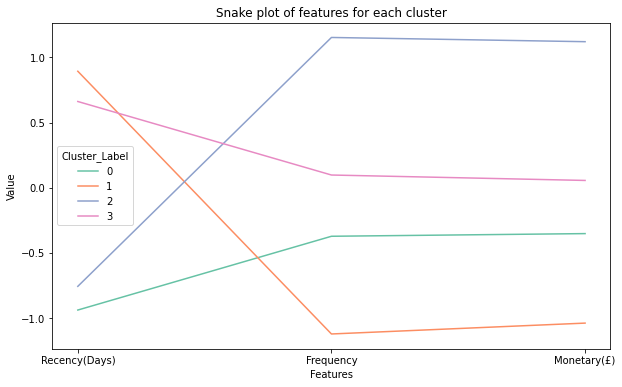

In [9]:
snakeplot(cluster_melt)
plt.show()

### Possible Intepretation

Cluster | Recency(Days)                 | Frequency (last 6 months) | Monetary(£) last 6 months | Examplar Interpretation |
---     | ---                           | ---                       | ---                       | --- |
0       | Active since last 2 weeks     | 100 transactions          | 1500                      | Very frequent customers with high monetary value. Could they be small businesses getting supplies from this online retailer? |
1       | Active since last 3 months    | 30 transactions           | 500                       | Inactive for a while, but has been typical in spending. How much should be invested in getting them back?|
2       | Active since last 3 months    | 7 transactions            | 150                       | Inactive for a while, and probably not rugular customer. Why is that the case? Are they not happy with the service?|
3       | Active since last 2 weeks     | 20 transactions           | 350                       | Active and regular, typical spending. How to provide them with even better services, so that they can be an influencer? |


Note:

For example, cluster 0, with 
- Recency = -0.93880, Frequency = -0.372588, Monetary = -0.352157, 

can be mapped back to the orignal range as 

- Recency = 9.672871, Frequency = 19.882943, Monetary = 346.019079, 

giving examplar interpretation show in table above. 